In [168]:
import gpflow
import numpy as np
import pandas as pd
import tensorflow as tf
from gpflow.base import _cast_to_dtype
from models.test_functions import TestFunLinearCorrelation as TestFun
from gpflow.utilities import to_default_float, print_summary
from gpflow.config import default_float
import matplotlib.pyplot as plt
import matplotlib as mpl
import pathlib as pl

mpl.style.use('mystyle.mplstyle')
save_path = pl.Path.home()

inch_conversion = 1/25.4
page_width = 169 *inch_conversion

# Comparing multioutput GP (indi model) to the LMC

In this notebook I compare a multioutput GPR model to the LMC. The multioutput model (called the individual or indi
model here) has the same hyperparameters for all surfaces, but treats the data for all the surfaces seperately.

The LMC is the linear model of coregionalisation.

The test functions used here are uncorrelated draws from a GP, so the functions can be thought of as unrelated.

In this notebook I look to answer the questions:
- [How does the LMC perform compared to the indi model?](#part1)
- [What happens if we set $\kappa$ to be untrainable?](#part2)
- [How can we make the LMC perform the same as the indi model?](#part3)



## Create the Test functions

Here we use the TestFun class to create a test function with the dimensions, latent dims, number of functions and noise
that we want. The test functions are independent draws of a GP.

As we are using the GPR, we need to have the same points on each surface


In [147]:
same_points = True
set_seed = True

In [148]:
plot_figs = True

train_inducing = True
opt_seed = 3
domain = [0, 2]
latent_dims = 2
latent_dims_lvmogp = 2
observed_dims = 1
n_fun = 6
n_points = [8]*6
max_points = 8
noise = 0.02
n_grid_points = 100
continuous_dims = ['x1', 'x2'][:observed_dims]
lengthscales_x = [0.3, 0.3]


if type(n_points) is int:
    n_points = [n_points]*n_fun

# Create the Test functions
if set_seed:
    seed = 2 #3 #2 #3 #5 #4 #1 #2
    np.random.seed(seed)
    tf.random.set_seed(seed)
else:
    seed = None


test_fun = TestFun(domain, seed, n_fun, observed_dims, latent_dims, max_points, noise, n_grid_points,
                                    same_points, lengthscales_x)

# data_X, fun_nos, data_y = test_fun.create_data(n_points=n_points)



Now we create the test data

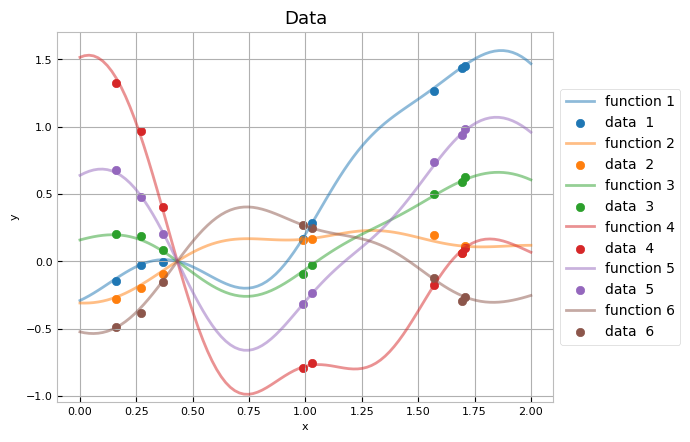

In [149]:
data_X, fun_nos, data_y = test_fun.create_data(n_points=n_points)
if plot_figs:
    test_fun.plot_data()

Plot the test functions and data on seperate plots so they can be seen better. Then plot the latent coordinates
of the test functions.

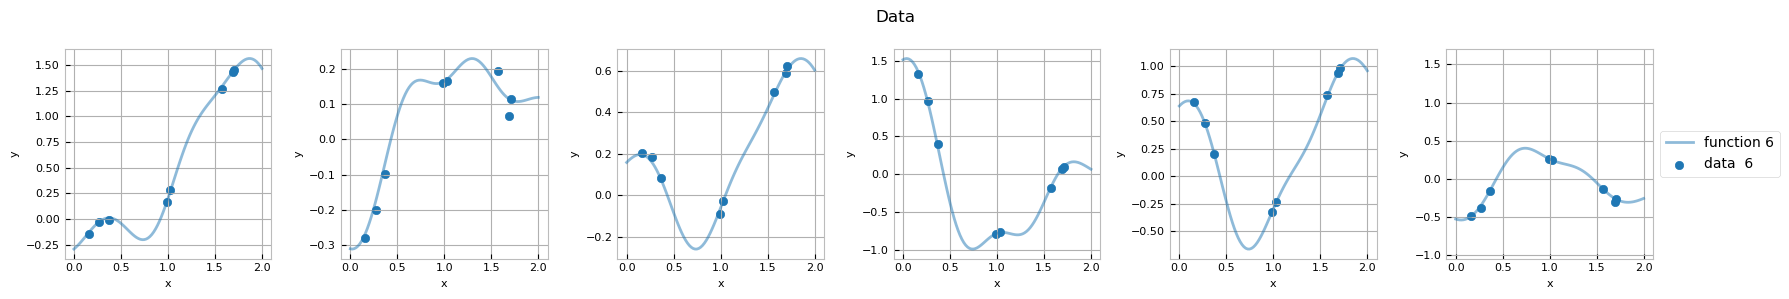

In [150]:
if plot_figs:
    test_fun.plot_data_seperate_plots()

In [151]:
x_new = np.linspace(domain[0], domain[1], 100).reshape(100, 1)
ys_new = []
for fun in test_fun.functions:
    y_new, _ = fun.predict_y(x_new)
    ys_new.append(y_new)

[Back to top](#Index:)

<a id='part1'></a>

## How does the LMC perform compared to the indi model?

First of all we fit an individual and a LMC model and look at the log marginal likelihood (LML) and the hyperparameters
to compare the models.

In this case where the test functions are unrelated, we would expect the LMC to perform the same as the individual model,
perhaps converging to the same model under the right circumstances.

In [152]:
continuous_dims = ['x1', 'x2'][:observed_dims]

Fit the individual model first

In [153]:
lengthscales_X = [0.1, 0.1][:len(continuous_dims)]

X_indi = data_X[:n_points[0]]
y_indi = np.array(test_fun.ys).squeeze().T

kernel_indi = gpflow.kernels.RBF(lengthscales=lengthscales_X)

indi_gp = gpflow.models.GPR(data=(tf.convert_to_tensor(X_indi,  dtype=default_float()),
                             tf.convert_to_tensor(y_indi,  dtype=default_float())), kernel=kernel_indi)

optimise the individual model

In [154]:
maxiter = 2000

indi_opt = gpflow.optimizers.Scipy().minimize(
    indi_gp.training_loss, indi_gp.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
)

Make predictions and plot

In [155]:
indi_mu, indi_sig2 = indi_gp.predict_y(x_new)

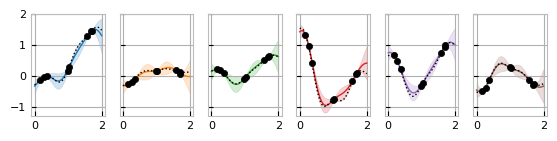

In [188]:
linewidth = 1

if plot_figs:
    fig, axs = plt.subplots(1, ncols=n_fun, figsize=(page_width, page_width/5), sharey=True)
    ax = axs.flatten()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 100
    for i, fun_no in enumerate(np.unique(fun_nos)):
        ax[i].plot(x_new, indi_mu[:, i], color=colors[i],linewidth=linewidth)
        ax[i].scatter(test_fun.xs[i], test_fun.ys[i], color='k', zorder=5, s=20)
        ax[i].plot(x_new, ys_new[i], linestyle=':', color='k', linewidth=linewidth )
        ax[i].fill_between(x_new.flatten(), indi_mu[:, i].numpy().flatten() + 2*np.sqrt(indi_sig2[:, i].numpy().flatten()),
                           indi_mu[:, i].numpy().flatten() - 2*np.sqrt(indi_sig2[:, i].numpy().flatten()), alpha=0.2,
                           color=colors[i])
        ax[i].set_ylim(-1.3, 2)
        # ax[i].set_aspect('equal')
    # fig.subplots_adjust(wspace=0.3)
    plt.savefig(save_path/'MOGP_predictions.svg')

Next do the same for the LMC model

In [190]:
lengthscales = lengthscales_X
X = np.hstack([data_X, fun_nos])
y = data_y
k = gpflow.kernels.RBF(lengthscales=lengthscales, active_dims=range(observed_dims))
coreg_k = gpflow.kernels.Coregion(output_dim=n_fun, rank=latent_dims,
                                              active_dims=[observed_dims])
coreg_k.W.assign(np.random.uniform(-0.1, 0.1, (n_fun, latent_dims)))
coreg_k.kappa.assign(np.random.uniform(0.01, 1, (n_fun,)))
cov = k * coreg_k
lmc = gpflow.models.GPR(data=(tf.convert_to_tensor(X, dtype=default_float()),
                                            tf.convert_to_tensor(y, dtype=default_float())), kernel=cov)

In [191]:
maxiter = 2000

lmc_opt = gpflow.optimizers.Scipy().minimize(
    lmc.training_loss, lmc.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
)

In [192]:
fun_nos_new = np.hstack([[fun_no]*len(x_new) for fun_no in np.unique(fun_nos)])
test = np.vstack([x_new]*n_fun)
x_new_lmc = np.hstack([np.vstack([x_new]*n_fun), fun_nos_new.reshape(len(fun_nos_new), 1)])
lmc_mu, lmc_sig2 = lmc.predict_f(x_new_lmc)

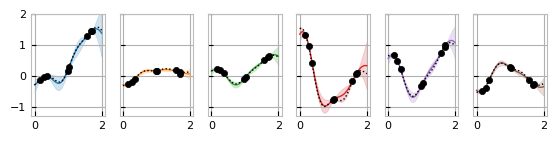

In [203]:
if plot_figs:
    fig, axs = plt.subplots(1, ncols=n_fun, figsize=(page_width, page_width/5), sharey=True)
    ax = axs.flatten()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 100
    for i, fun_no in enumerate(np.unique(fun_nos)):
        idx = np.where(fun_nos_new ==fun_no)[0]
        ax[i].plot(x_new, lmc_mu.numpy()[idx], color=colors[i],linewidth=linewidth)
        ax[i].scatter(test_fun.xs[i], test_fun.ys[i], color='k', zorder=5, s=20)
        ax[i].plot(x_new, ys_new[i], linestyle=':', color='k',linewidth=linewidth)
        ax[i].fill_between(x_new.flatten(), lmc_mu.numpy()[idx].flatten() + 2*np.sqrt(lmc_sig2.numpy()[idx].flatten()),
                           lmc_mu.numpy()[idx].flatten() - 2*np.sqrt(lmc_sig2.numpy()[idx].flatten()), alpha=0.2, color=colors[i])
        ax[i].set_ylim(-1.3, 2)
    plt.savefig(save_path/'LMC_predictions.svg')

print the W and kappa hyperparameters of the LMC.

When the functions are unrelated we expect the W to go very small as there is no relationship between the functions, so
there should be no correlation.

In this case the W doesn't go especially small and the kappas are all different.

In [194]:
print('W', lmc.kernel.kernels[1].W.numpy())
print('kappa',lmc.kernel.kernels[1].kappa.numpy())

W [[-655711.08909289 -634522.33032384]
 [  22731.48264763 -214625.39163879]
 [-352427.2229688   -98112.34692543]
 [-409264.61546023  813152.96553919]
 [-649572.98700249   43155.65636774]
 [ 267037.3913855  -209583.66486743]]
kappa [117105.04741063      0.              0.          38999.13147434
 184948.95557867      0.        ]


Compare the log marginal likelihood and hyperparameters of the indi and LMC models.
Interestingly the lml of the lmc is higher than that of the individual. I have a hyppthesis that this might be because
the LMC is essentially letting the variance of each function be different, rather than making them all the same. This
explains why the kappas above are all different.

In [195]:
print('log marginal likelihood')
print('indi', indi_gp.log_marginal_likelihood())
print('lmc', lmc.log_marginal_likelihood())

log marginal likelihood
indi tf.Tensor(17.083055891363347, shape=(), dtype=float64)
lmc tf.Tensor(83.13985287594082, shape=(), dtype=float64)


In [196]:
print('indi')
print_summary(indi_gp)
print('lmc')
print_summary(lmc)

indi
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value     │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.33815   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (1,)    │ float64 │ [0.36007] │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0005    │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═══════

<a id='part2'></a>
## How can we make the LMC perform the same as the indi model?

To make the LMC perform the same as the individual model we need to:

1) set W to be **0** and

2) set $\kappa$ = **1** .

Just setting W to be **0** isn't enough to make the LMC behave exactly like the individual. In that case the LML of the
LMC ends up somewhere between that of the individual and that of the LMC with no constraints on W or $\kappa$.


In [197]:

lengthscales = lengthscales_X
X = np.hstack([data_X, fun_nos])
y = data_y
k = gpflow.kernels.RBF(lengthscales=lengthscales, active_dims=range(observed_dims))
coreg_k = gpflow.kernels.Coregion(output_dim=n_fun, rank=1,
                                              active_dims=[observed_dims])
cov = k * coreg_k

lmc_noW = gpflow.models.GPR(data=(tf.convert_to_tensor(X, dtype=default_float()),
                                            tf.convert_to_tensor(y, dtype=default_float())), kernel=cov)
lmc_noW.kernel.kernels[1].W.assign(np.array([[1e-6]*n_fun]).T)
gpflow.set_trainable(lmc_noW.kernel.kernels[1].W, False)
lmc_noW.kernel.kernels[1].kappa.assign(np.array([1]*n_fun))
gpflow.set_trainable(lmc_noW.kernel.kernels[1].kappa, False)

In [198]:
maxiter = 2000

lmc_noW_opt = gpflow.optimizers.Scipy().minimize(
    lmc_noW.training_loss, lmc_noW.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
)

In [199]:
fun_nos_new = np.hstack([[fun_no]*len(x_new) for fun_no in np.unique(fun_nos)])
test = np.vstack([x_new]*n_fun)
x_new_lmc_noW = np.hstack([np.vstack([x_new]*n_fun), fun_nos_new.reshape(len(fun_nos_new), 1)])
lmc_noW_mu, lmc_noW_sig2 = lmc_noW.predict_f(x_new_lmc)

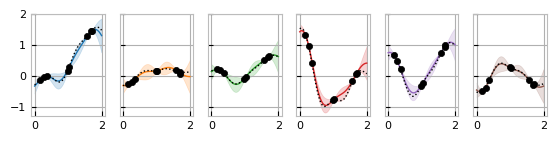

In [202]:
if plot_figs:
    fig, axs = plt.subplots(1, ncols=n_fun, figsize=(page_width, page_width/5), sharey=True)
    ax = axs.flatten()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 100
    for i, fun_no in enumerate(np.unique(fun_nos)):
        idx = np.where(fun_nos_new ==fun_no)[0]
        ax[i].plot(x_new, lmc_noW_mu.numpy()[idx], color=colors[i],linewidth=linewidth)
        ax[i].scatter(test_fun.xs[i], test_fun.ys[i], color='k', zorder=5, s=20)
        ax[i].plot(x_new, ys_new[i], linestyle=':', color='k',linewidth=linewidth)
        ax[i].fill_between(x_new.flatten(), lmc_noW_mu.numpy()[idx].flatten() + 2*np.sqrt(lmc_noW_sig2.numpy()[idx].flatten()),
                           lmc_noW_mu.numpy()[idx].flatten() - 2*np.sqrt(lmc_noW_sig2.numpy()[idx].flatten()), alpha=0.2, color=colors[i])
        ax[i].set_ylim(-1.3, 2)
    plt.savefig(save_path/'LMC_noW_predictions.svg')

Print the log marginal likelihoods. You can see from below the LMC with W and kappa has the same LML as the individual
model and the same hyperparameters, meaning we are recovering the same model.

In [111]:
print('log marginal likelihood')
print('indi', indi_gp.log_marginal_likelihood())
print('lmc', lmc.log_marginal_likelihood())
print('lmc W = 0, kappa = 1', lmc_noW.log_marginal_likelihood())

log marginal likelihood
indi tf.Tensor(17.083055891363347, shape=(), dtype=float64)
lmc tf.Tensor(84.14430509230127, shape=(), dtype=float64)
lmc W = 0, kappa = 1 tf.Tensor(17.08305589137096, shape=(), dtype=float64)


In [112]:
print('indi')
print_summary(indi_gp)
print('lmc')
print_summary(lmc)
print('lmc_noW')
print_summary(lmc_noW)

indi
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value     │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.33815   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (1,)    │ float64 │ [0.36007] │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0005    │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═══════

The lengthscale, kernel variance and likelihood variance of the setting W and kappa model has recovered that of the
individual model.

In [206]:
W = lmc.kernel.kernels[1].W
kappa = lmc.kernel.kernels[1].kappa

In [207]:
print(tf.matmul(W, W, transpose_b=True) + tf.linalg.diag(kappa))

tf.Tensor(
[[ 8.32575737e+11  1.21279318e+11  2.93344913e+11 -2.47604368e+11
   3.98548983e+11 -4.21138633e+10]
 [ 1.21279318e+11  4.65807790e+10  1.30462076e+10 -1.83826465e+11
  -2.40280567e+10  5.10521320e+10]
 [ 2.93344913e+11  1.30462076e+10  1.33830980e+11  6.44556460e+10
   2.24693101e+11 -7.35485010e+10]
 [-2.47604368e+11 -1.83826465e+11  6.44556460e+10  8.28715310e+11
   3.00939389e+11 -2.79712534e+11]
 [ 3.98548983e+11 -2.40280567e+10  2.24693101e+11  3.00939389e+11
   4.23807661e+11 -1.82504997e+11]
 [-4.21138633e+10  5.10521320e+10 -7.35485010e+10 -2.79712534e+11
  -1.82504997e+11  1.15234281e+11]], shape=(6, 6), dtype=float64)
